# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [2]:
!pip install wntr
!pip install scipy
%matplotlib inline

import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.metrics import confusion_matrix, recall_score, precision_score

     |████████████████████████████████| 4.2 MB 28.8 MB/s 


In [3]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader
from utils.Datagenerator import Datagenerator

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)
importlib.reload(utils.Datagenerator)

<module 'utils.Datagenerator' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Datagenerator.py'>

## Main

### Plotting

In [4]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

def print_metrics(y_true, y_pred):
  print(confusion_matrix(y_true, y_pred))
  print(f'Recall (Sns): {round(recall_score(y_true, y_pred), 3)}\tWie gut wurden echte Lecks erkannt?')
  print(f'Specificity:  {round(recall_score(y_true, y_pred, pos_label=0), 3)}\tWie gut wurde \'alles ok\' erkannt?')
  print(f'Precision:    {round(precision_score(y_true, y_pred), 3)}\tWie viele erkannte lecks waren auch wirklich Lecks?')

### Testing

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


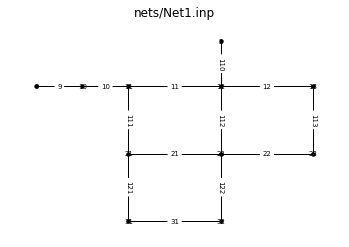

In [5]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()
gen = Datagenerator(wdn)

Leakage at 182 Day 7 Hour 14


<Figure size 432x288 with 0 Axes>

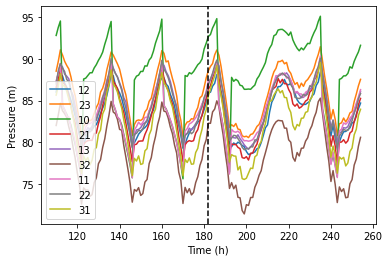

<Figure size 432x288 with 0 Axes>

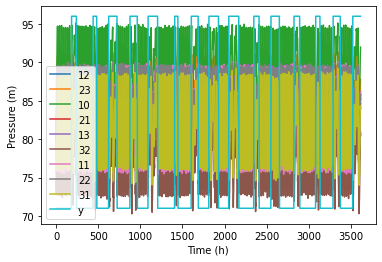

In [17]:
X, y = gen.gen_multi_data('12', include_time=False, noise_strength=0.15, num_sim=15)
show_data(X, y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
from sklearn import svm

# Create the model
model = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

In [9]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score

print(confusion_matrix(y_test, y_pred))
print(f'Recall:      {round(recall_score(y_test, y_pred), 3)}')
print(f'Precision:   {round(precision_score(y_test, y_pred), 3)}')
print(f'Specificity: {round(recall_score(y_test, y_pred, pos_label=0), 3)}')

NameError: ignored

In [7]:
from sklearn import svm

# Create the model
model = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
model.fit(X, y)

# Predict the value of the digit on the test subset
y_pred = model.predict(X)

In [ ]:
show_data(X, medfilt(y_pred, 5))

print_metrics(y, medfilt(y_pred, 5))

In [ ]:
X, y = gen.gen_multi_data('', include_time=False, noise_strength=0.15)
show_data(X, y)

In [ ]:
y_pred_all = model.predict(X)
show_data(X, y_pred_all)
show_data(X, medfilt(y_pred_all, 3))
show_data(X, medfilt(y_pred_all, 5))
show_data(X, medfilt(y_pred_all, 11))

In [12]:
for i in [1, 3, 5, 11]:
  print(f'Median Filter {i}')
  print_metrics(y, medfilt(y_pred_all, i))
  print()

Median Filter 1
[[1168   37]
 [   0    0]]
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  0.969	Wie gut wurde 'alles ok' erkannt?
Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?

Median Filter 3
[[1205]]
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?

Median Filter 5
[[1205]]
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?

Median Filter 11
[[1205]]
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0

### Ergebnisse:
SVM ohne 'Time of Day':
```
[[102  24]
 [ 30  25]]
Recall:      0.455
Precision:   0.51
Specificity: 0.81
```
SVM mit 'Time of Day':
```
[[104  16]
 [ 24  37]]
Recall:      0.607
Precision:   0.698
Specificity: 0.867
```



Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```
- **Sensitivity/ Recall**: Wie gut wurden echte Lecks erkannt?
- **Precision**: Wie viele erkannte lecks waren auch wirklich Lecks?
- **Specificity**: Wie gut wurde 'alles ok' erkannt?


Median Filter 1
Recall:      0.567
Precision:   0.882
Specificity: 0.955

Median Filter 3
Recall:      0.56
Precision:   0.969
Specificity: 0.989

Median Filter 5
Recall:      0.551
Precision:   1.0
Specificity: 1.0

Median Filter 11
Recall:      0.529
Precision:   1.0
Specificity: 1.0

Plan:
- Eigene Klasse "Klassifikator" erbt von `BaseEstimator` inkl. `.fit()` und `.predict()`
- Darin `.score()` mit automaischer Konvertierung
- Vorbereiten für eigenes GridSearch
- Train-Test-Split mit einzelne Aufrufen von `get_single_data()` als Datenpunkte

In [16]:
from sklearn.base import BaseEstimator

class ClassificationModel(BaseEstimator):
  def __init__(self, model):
    self.model = model

  def fit(self, X, y):
    self.model.fit(X, y)
    return self

  def predict(self, X):
    return self.model.predict(X)

  def score(self, X, y):
    return 0

In [18]:
from sklearn import svm

# Create the model
model = ClassificationModel(svm.SVC(gamma=0.001))

# Learn the digits on the train subset
model.fit(X, y)

# Predict the value of the digit on the test subset
y_pred = model.predict(X)

Leakage at 193 Day 8 Hour 1


<Figure size 432x288 with 0 Axes>

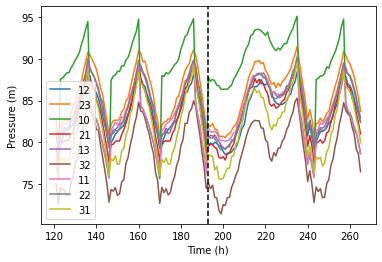

<Figure size 432x288 with 0 Axes>

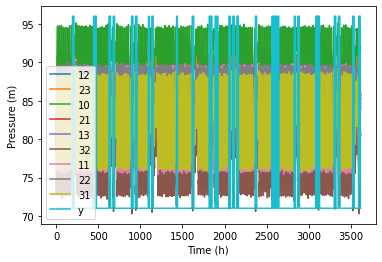

[[2387    0]
 [ 758  470]]
Recall (Sns): 0.383	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?


In [19]:
show_data(X, medfilt(y_pred, 5))

print_metrics(y, medfilt(y_pred, 5))

Leakage at 123 Day 5 Hour 3


<Figure size 432x288 with 0 Axes>

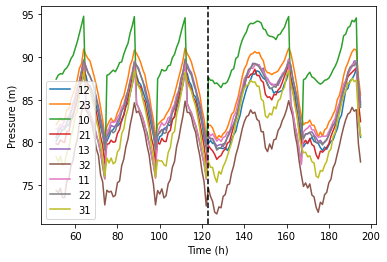

<Figure size 432x288 with 0 Axes>

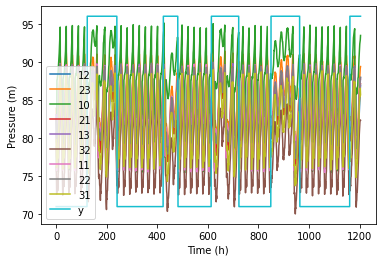

In [23]:
X, y = gen.gen_multi_data('12', include_time=False, noise_strength=0.15)
show_data(X, y)

Leakage at 3 Day 0 Hour 3


<Figure size 432x288 with 0 Axes>

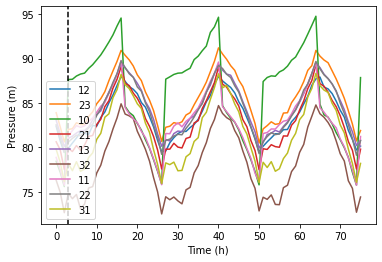

<Figure size 432x288 with 0 Axes>

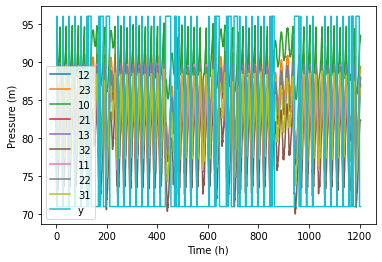

Leakage at 127 Day 5 Hour 7


<Figure size 432x288 with 0 Axes>

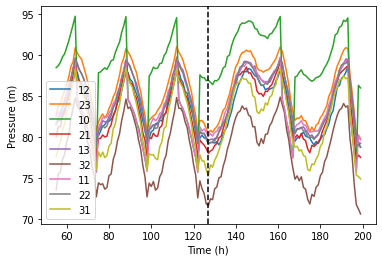

<Figure size 432x288 with 0 Axes>

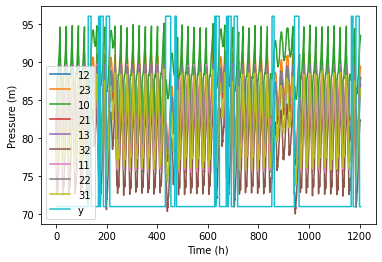

Leakage at 127 Day 5 Hour 7


<Figure size 432x288 with 0 Axes>

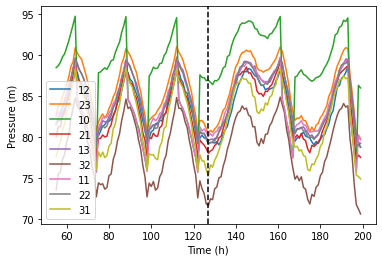

<Figure size 432x288 with 0 Axes>

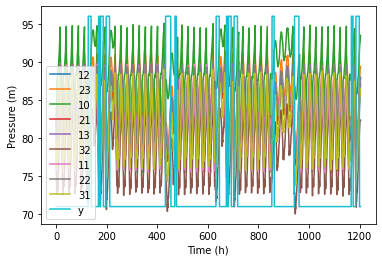

Leakage at 126 Day 5 Hour 6


<Figure size 432x288 with 0 Axes>

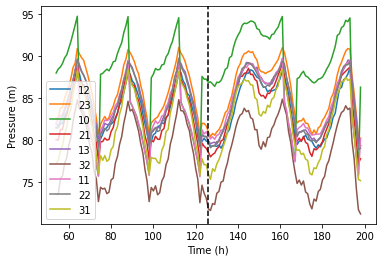

<Figure size 432x288 with 0 Axes>

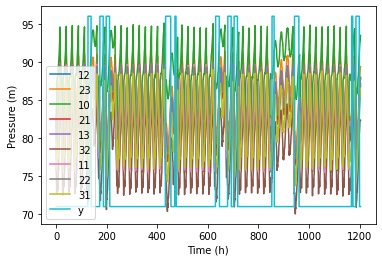

In [24]:
y_pred_all = model.predict(X)
show_data(X, y_pred_all)
show_data(X, medfilt(y_pred_all, 3))
show_data(X, medfilt(y_pred_all, 5))
show_data(X, medfilt(y_pred_all, 11))

In [25]:
for i in [1, 3, 5, 11]:
  print(f'Median Filter {i}')
  print_metrics(y, medfilt(y_pred_all, i))
  print()

Median Filter 1
[[731  32]
 [284 158]]
Recall (Sns): 0.357	Wie gut wurden echte Lecks erkannt?
Specificity:  0.958	Wie gut wurde 'alles ok' erkannt?
Precision:    0.832	Wie viele erkannte lecks waren auch wirklich Lecks?

Median Filter 3
[[763   0]
 [284 158]]
Recall (Sns): 0.357	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?

Median Filter 5
[[763   0]
 [286 156]]
Recall (Sns): 0.353	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?

Median Filter 11
[[763   0]
 [286 156]]
Recall (Sns): 0.353	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?

